# Simple Physical Maxwell Model of Viscoelasticity and Molecular Weight Distribution
### Angel Villalba-Rodríguez - A00828035@itesm.mx
### Constanza Álvarez-López - A00829469@itesm.mx
### Osamu Katagiri-Tanaka - A01212611@itesm.mx
### Juan Jesús Rocha-Cuervo - A01752555@itesm.mx
---

In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
import statistics as stat

from scipy import special, optimize

---
# a) Fit the relaxation modulus of the two materials given in the excel file G(t) PBR8 using as many Maxwell elements as you need. Plot each Maxwell element in the same plot of G(t) vs. time to show that by adding them up you can fit the experimental curve.

In [2]:
filename = "./GT_PBR8.csv";
df = pd.read_csv(filename, sep=',');
display(df.head(10))

,time_PBR8,G_PBR8,time_HDPE,G_HDPE
0,0.0387,33200.0,0.001,1.067754e+08
1,0.0407,31400.0,0.002,1.066869e+08
2,0.0428,29700.0,0.003,1.066041e+08
3,0.0450,28000.0,0.004,1.065264e+08
4,0.0474,26500.0,0.005,1.064535e+08
5,0.0499,25000.0,0.006,1.063850e+08
6,0.0525,23600.0,0.007,1.063205e+08
7,0.0552,22200.0,0.008,1.062597e+08
8,0.0581,20900.0,0.009,1.062023e+08
9,0.0611,19700.0,0.010,1.061480e+08


## Generalized Maxwell model
## $$ G(t) = G_{\infty} + \sum_{i = 1}^{n} G_{i} e^{-\frac{G_{i}}{\eta_{i}}t} $$
### and
## $$ \tau_{i} = \frac{\eta_{i}}{G_{i}} $$
### where:
#### $G_{\infty}$ is the elastic modulus at $t = \infty$
#### $G_{i}$ is the elastic modulus of the ith spring
#### $\eta_{i}$ is the viscosity of the dashpot for the ith series
#### $n$ is the number of spring–dashpot series
#### $\tau_{i}$ is the relaxaton time for a single spring–dashpot series

In [3]:
# p[0]   is E_infty
# p[n]   is E_i for the ith series
# p[n+1] is eta_i for the ith series
def _G(t, *p):
    sum = 0
    E_infty = p[0]
    p = np.delete(p, 0)
    for n in range(0, len(p), 2):
        sum = sum + p[n]*np.exp(-(p[n]/p[n+1])*t)
    return E_infty + sum;

# function to calculate the relaxaton time
def _tau(E, eta):
    return eta/E;

## Fit and Plot

In [4]:
def fit_G(x, y, n, plotname):
    
    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));
    ax0 = plt.gca()

    # plot dataset
    plt.scatter(x, y) #, label='data')

    # Initial guess
    E_infty = [3000000]
    E_and_eta = [25000000, 125000000]*n
    p = E_infty + E_and_eta

    # Fit the model
    model      = optimize.curve_fit(_G, x, y, p, bounds=(0, np.inf));
    parameters = model[0]

    # Show the fitting parameters
    print(parameters)

    # Plot fit
    y_fit = _G(x, *parameters)
    plt.plot(x, y_fit, linewidth=3, label = 'fit');

    # plot elastic modulus at t = infty
    E_infty = parameters[0]
    plt.hlines(E_infty, x.min(), x.max(), linewidth=1, label = r'$G_\infty = $' + str(round(E_infty,2)))

    # remove the 1st element as it E_infty
    parameters = np.delete(parameters, 0)

    # Plot each Maxwell element
    cnt = 1;
    for i in range(0, len(parameters), 2):
        E = parameters[i]
        eta = parameters[i+1]
        y_fit = E*np.exp(-(E/eta)*x)
        plt.plot(x, y_fit, linewidth=1, label = r'$G_{{{}}} = $'.format(cnt) + str(round(E, 2)) + '; ' +
                r'$\eta_{{{}}} = $'.format(cnt) + str(round(eta, 2)) + '; ' + 
                r'$\tau_{{{}}} = $'.format(cnt) + str(round(_tau(E, eta), 2)) + '; ');
        cnt = cnt + 1

    # Format and Display plots
    ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
    plt.yscale('linear');
    plt.xscale('log');
    plt.xlabel(r'$t$', fontsize=24);
    plt.ylabel(r'$G(t)$', fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 24});
    plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
    display(plt);

## 3.a)

[  1189.38753827  22865.66645208   2196.76263171 405258.21607028
   2642.82964617  73937.70832936   1843.01738056]


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

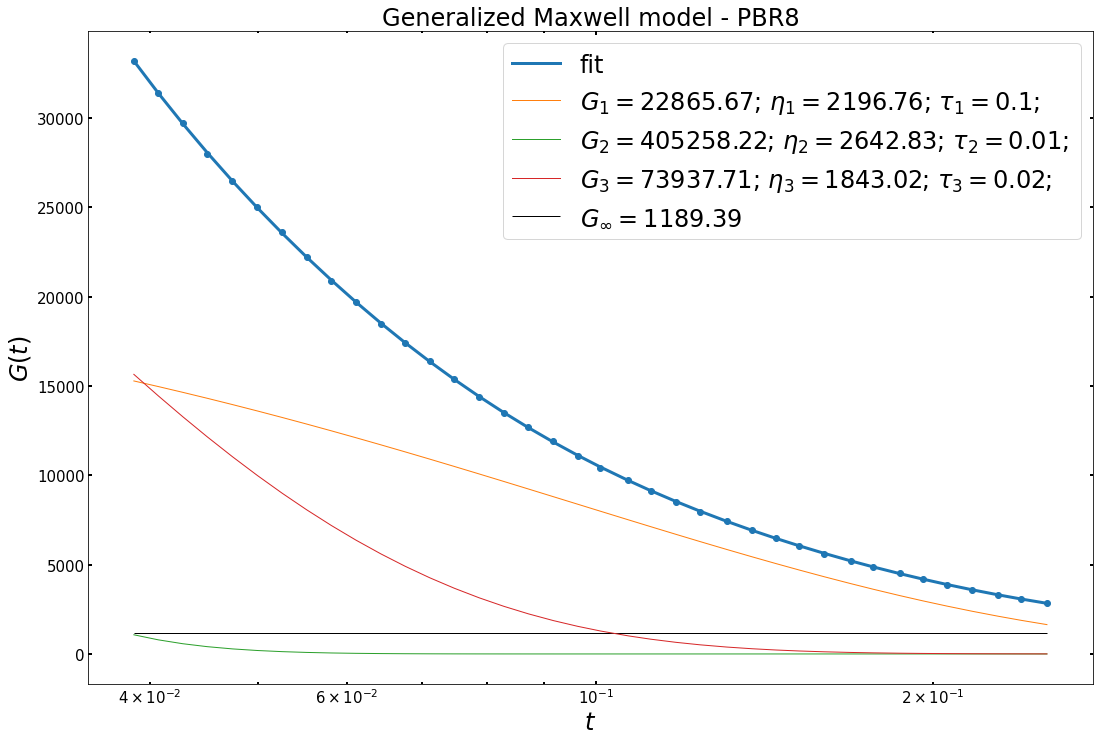

In [5]:
fit_G(
    pd.Series(df['time_PBR8']).dropna(),
    pd.Series(df['G_PBR8']).dropna(),
    3,
    "Generalized Maxwell model - PBR8")

[2.40633089e+06 2.76266435e+07 1.22401536e+08 7.50324277e+07
 2.66481677e+10]


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

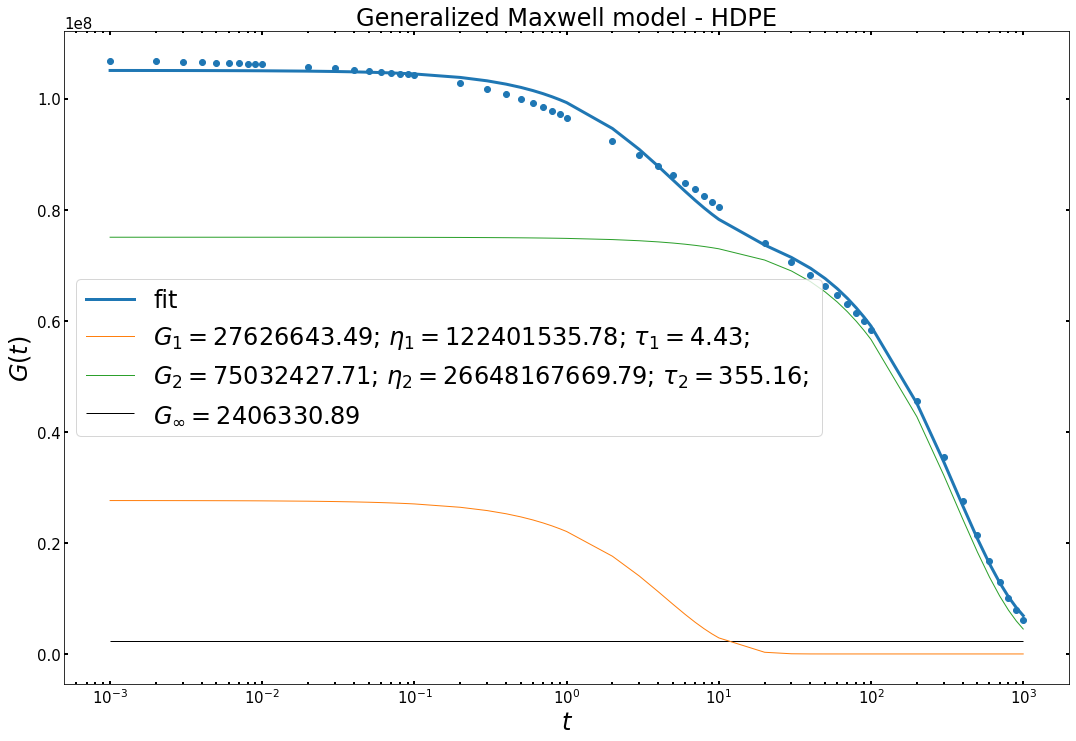

In [6]:
fit_G(
    pd.Series(df['time_HDPE']).dropna(),
    pd.Series(df['G_HDPE']).dropna(),
    2,
    "Generalized Maxwell model - HDPE")

---
# b) Calculate the Mn, Mw, Mz and PDI for the PAR0, PAR5, PBR0 and PBR8 resins given to you in the excel file PPRG and PPCR MWD Data and make a table with the information

In [7]:
filename = "./PPRG_and_PPCR_MWD_Data.csv";
df = pd.read_csv(filename, sep=',');
df = df.reindex(sorted(df.columns), axis=1);
display(df)

,Fcontr_Mwi,Fcontr_grs,PAR0_Mwi,PAR0_grs,PAR5_Mwi,PAR5_grs,PBR0_Mwi,PBR0_grs,PBR8_Mwi,PBR8_grs,PCR0_Mwi,PCR0_grs,PCR4_Mwi,PCR4_grs,PDR0_Mwi,PDR0_grs,PDR4_Mwi,PDR4_grs,Pcontrol_Mwi,Pcontrol_grs
0,4325840.0,0.050568,8201795.0,0.038465,1786184.0,0.045290,3979280.0,0.058376,1786184.0,0.044906,4483361,0.049092,1755270.0,0.045130,3196249.0,0.065448,1870409.0,0.051590,1668694.0,0.050047
1,4041299.0,0.063512,7568476.0,0.048446,1668694.0,0.057249,3672011.0,0.075563,1668694.0,0.054670,4189972,0.061597,1647220.0,0.053874,2987088.0,0.072703,1755270.0,0.059620,1558932.0,0.056917
2,3775473.0,0.077042,6984059.0,0.054970,1558932.0,0.072209,3388469.0,0.090493,1558932.0,0.069375,3915782,0.075341,1545820.0,0.064607,2791614.0,0.084062,1647220.0,0.077725,1456389.0,0.072575
3,3527133.0,0.089443,6444770.0,0.078034,1456389.0,0.091155,3126821.0,0.127890,1456389.0,0.088586,3659535,0.079329,1450663.0,0.084665,2608932.0,0.102725,1545820.0,0.089552,1360592.0,0.094377
4,3295128.0,0.100551,5947123.0,0.092401,1360592.0,0.106813,2885377.0,0.150261,1360592.0,0.103054,3420056,0.098842,1361363.0,0.095481,2438205.0,0.112532,1450663.0,0.098361,1271096.0,0.113108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1868,0.056099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1746,0.057532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1632,0.050602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1525,0.041852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The wheight fraction $X_i$ is already normalized
### (sums are ~100)

In [8]:
# Iterate the data per sample
sample_name = pd.Series([])
sample_id = '';
for i in range(len(df.columns)):
    if ("Mwi" in df.columns[i]):
        sample_id = df.columns[i].split('_')[0];
        sample_name = sample_name.append(pd.Series(sample_id))
        print(sample_id, df[sample_id + '_grs'].sum())

df_M = pd.DataFrame()
df_M['Sample'] = sample_name

Fcontr 99.999999995
PAR0 100.000000002
PAR5 100.00000000400001
PBR0 100.0
PBR8 100.000000004
PCR0 100.000000001
PCR4 99.999999997
PDR0 99.999999999
PDR4 100.00000000099999
Pcontrol 99.99999999900001


## Compute the amount of molecules of size $M_i$
## $$ N_i = \frac{X_i}{M_i} $$

In [9]:
# Iterate the data per sample
sample_id = '';
for i in range(len(df.columns)):
    if ("Mwi" in df.columns[i]):
        sample_id = df.columns[i].split('_')[0];
        df[sample_id + '_Ni'] = df[sample_id + '_grs'] / df[sample_id + '_Mwi']

df = df.reindex(sorted(df.columns), axis=1);
display(df)

,Fcontr_Mwi,Fcontr_Ni,Fcontr_grs,PAR0_Mwi,PAR0_Ni,PAR0_grs,PAR5_Mwi,PAR5_Ni,PAR5_grs,PBR0_Mwi,...,PCR4_grs,PDR0_Mwi,PDR0_Ni,PDR0_grs,PDR4_Mwi,PDR4_Ni,PDR4_grs,Pcontrol_Mwi,Pcontrol_Ni,Pcontrol_grs
0,4325840.0,1.168968e-08,0.050568,8201795.0,4.689776e-09,0.038465,1786184.0,2.535560e-08,0.045290,3979280.0,...,0.045130,3196249.0,2.047647e-08,0.065448,1870409.0,2.758209e-08,0.051590,1668694.0,2.999193e-08,0.050047
1,4041299.0,1.571582e-08,0.063512,7568476.0,6.401041e-09,0.048446,1668694.0,3.430780e-08,0.057249,3672011.0,...,0.053874,2987088.0,2.433916e-08,0.072703,1755270.0,3.396644e-08,0.059620,1558932.0,3.651000e-08,0.056917
2,3775473.0,2.040581e-08,0.077042,6984059.0,7.870749e-09,0.054970,1558932.0,4.631941e-08,0.072209,3388469.0,...,0.064607,2791614.0,3.011216e-08,0.084062,1647220.0,4.718579e-08,0.077725,1456389.0,4.983220e-08,0.072575
3,3527133.0,2.535866e-08,0.089443,6444770.0,1.210815e-08,0.078034,1456389.0,6.258966e-08,0.091155,3126821.0,...,0.084665,2608932.0,3.937442e-08,0.102725,1545820.0,5.793177e-08,0.089552,1360592.0,6.936500e-08,0.094377
4,3295128.0,3.051497e-08,0.100551,5947123.0,1.553702e-08,0.092401,1360592.0,7.850491e-08,0.106813,2885377.0,...,0.095481,2438205.0,4.615378e-08,0.112532,1450663.0,6.780437e-08,0.098361,1271096.0,8.898453e-08,0.113108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute the number average molecular weight $M_n$
## $$ M_n = \frac{\sum X_i}{\sum \frac{X_i}{M_i}} $$

In [10]:
def _Mn(X_i, M_i):
    nume = X_i.sum()
    deno = (X_i/M_i).sum()
    res = nume / deno
    return res

# Iterate the data per sample
sample_Mn = pd.Series([])
sample_id = '';
for i in range(len(df.columns)):
    if ("Mwi" in df.columns[i]):
        sample_id = df.columns[i].split('_')[0];
        Mn = _Mn(df[sample_id + '_grs'],df[sample_id + '_Mwi'])
        sample_Mn = sample_Mn.append(pd.Series(Mn))

df_M['Mn'] = sample_Mn

## Compute the weight average molecular weight $M_W$
## $$ M_W = \frac{\sum X_i M_i}{\sum X_i} $$

In [11]:
def _Mw(X_i, M_i):
    nume = (X_i*M_i).sum()
    deno = X_i.sum()
    res = nume / deno
    return res

# Iterate the data per sample
sample_Mw = pd.Series([])
sample_id = '';
for i in range(len(df.columns)):
    if ("Mwi" in df.columns[i]):
        sample_id = df.columns[i].split('_')[0];
        Mw = _Mw(df[sample_id + '_grs'], df[sample_id + '_Mwi'])
        sample_Mw = sample_Mw.append(pd.Series(Mw))

df_M['Mw'] = sample_Mw

## Compute the higher average molecular weight $M_Z$
## $$ M_Z = \frac{\sum X_i {M_i}^2}{\sum X_i M_i} $$

In [12]:
def _Mz(X_i, M_i):
    nume = (X_i*M_i**2).sum()
    deno = (X_i*M_i).sum()
    res = nume / deno
    return res

# Iterate the data per sample
sample_Mz = pd.Series([])
sample_id = '';
for i in range(len(df.columns)):
    if ("Mwi" in df.columns[i]):
        sample_id = df.columns[i].split('_')[0];
        Mz = _Mz(df[sample_id + '_grs'], df[sample_id + '_Mwi'])
        sample_Mz = sample_Mz.append(pd.Series(Mz))

df_M['Mz'] = sample_Mz

## Compute the polydispersity index PDI
## $$ PDI = \frac{M_W}{M_n} $$

## 3.b)

In [13]:
df_M['PDI'] = df_M['Mw'] / df_M['Mn']

df_M = df_M.set_index('Sample')
print(df_M)

                    Mn             Mw            Mz       PDI
Sample                                                       
Fcontr    50160.425188  298001.783723  1.015581e+06  5.940974
PAR0      48574.562930  459847.237678  1.808875e+06  9.466832
PAR5      42193.674367  157422.410871  4.007308e+05  3.730948
PBR0      49563.779135  295124.741069  9.499433e+05  5.954444
PBR8      41689.223124  161689.897564  4.071026e+05  3.878458
PCR0      42036.189129  291000.838993  1.039724e+06  6.922627
PCR4      36680.018502  156556.866667  4.026423e+05  4.268179
PDR0      36557.177807  230864.613508  7.825735e+05  6.315165
PDR4      36151.908313  160293.206922  4.372889e+05  4.433880
Pcontrol  40219.815961  153865.232669  3.848122e+05  3.825608


---
# Make two plots for the molecular weight distribution of the pairs given below and write down your observations (note use the data given in the excel file PPRG and PPCR MWD Data)
<ol>
    <li>PAR0 and PAR5. (together)</li>
    <li>PBR0 and PBR8 (together)</li>
</ol>

In [14]:
def MWD(sample_set, plotname):

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));
    ax0 = plt.gca()

    # Plot curves
    sample_id = '';
    for i in range(len(df.columns)):
        if ("Mwi" in df.columns[i]) and (sample_set in df.columns[i]):
            sample_id = df.columns[i].split('_')[0];
            plt.plot(np.log(df[sample_id + '_Mwi']), df[sample_id + '_Ni'], linewidth=3, label = sample_id + ':\n'
                    r'$log M_n = $' + str(round(np.log(df_M.loc[sample_id,'Mn']),2)) + '\n'
                    r'$log M_W = $' + str(round(np.log(df_M.loc[sample_id,'Mw']),2)) + '\n'
                    r'$log M_Z = $' + str(round(np.log(df_M.loc[sample_id,'Mz']),2)) + '\n'
                    r'$PDI = $' + str(round(df_M.loc[sample_id,'PDI'],2)));

    # Format and Display plots
    ax0.tick_params(which='both', direction='in', width=2, bottom=True, top=True, left=True, right=True);
    plt.yscale('linear');
    plt.xscale('linear');
    plt.xlabel(r'$log M_i$', fontsize=24);
    plt.ylabel(r'$N_i$', fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 24});
    plt.savefig('plt_' + plotname + '.png', dpi=300, bbox_inches='tight');
    display(plt);

## 3.c)

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

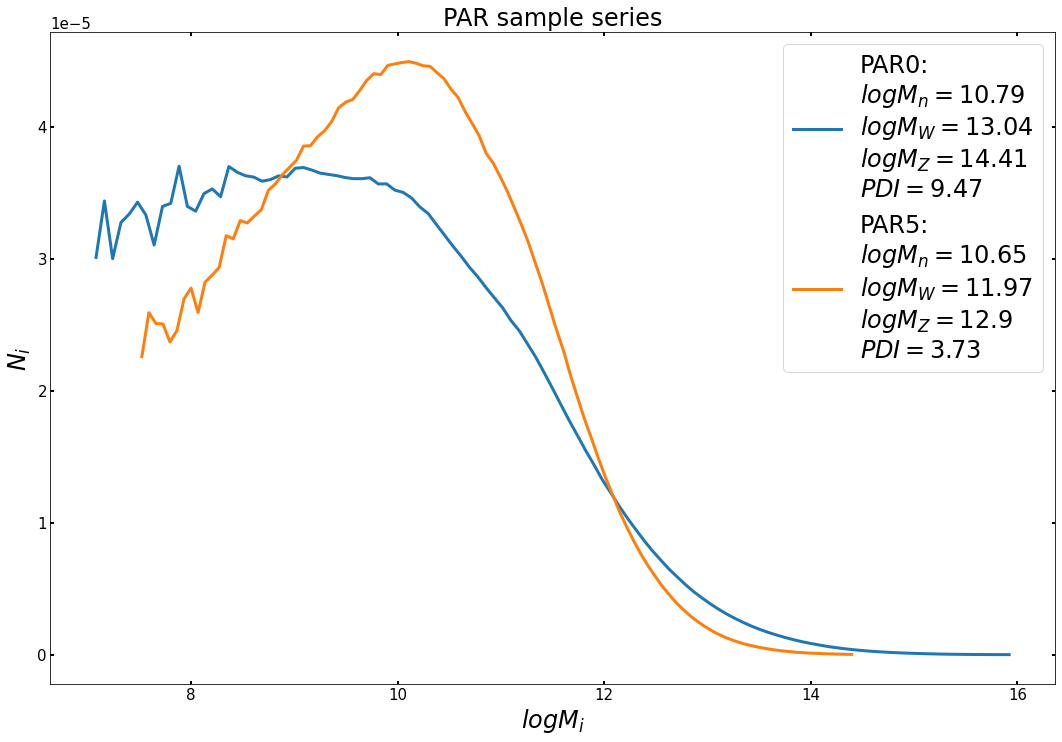

In [15]:
MWD('PAR', 'PAR sample series')

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

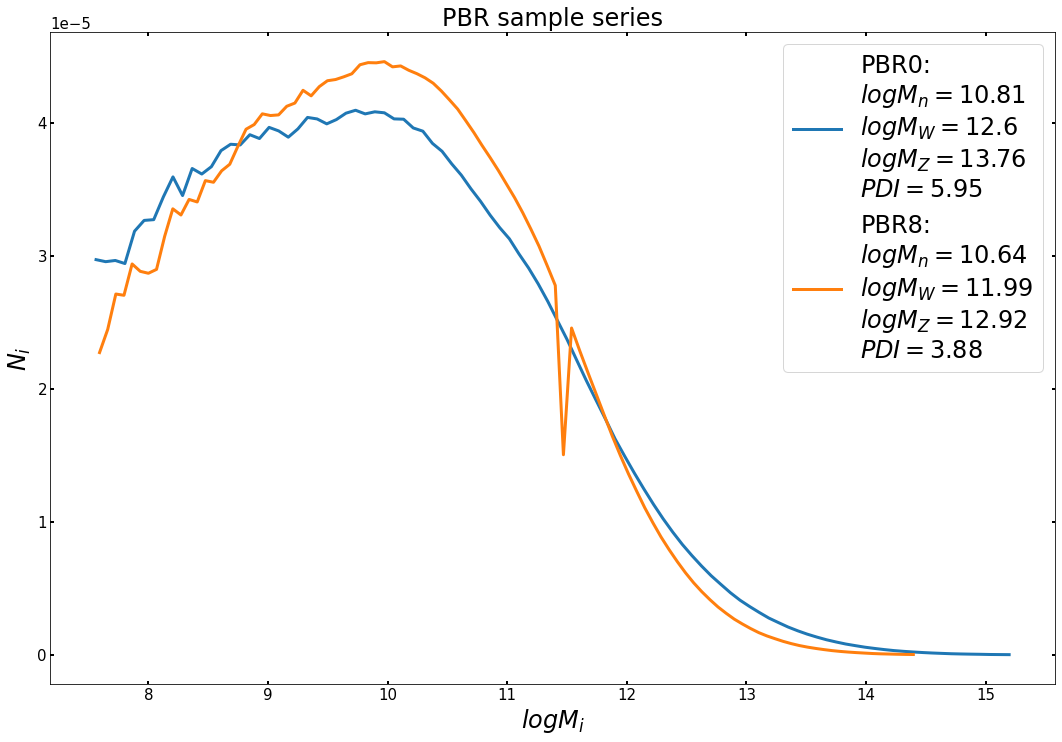

In [16]:
MWD('PBR', 'PBR sample series')

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

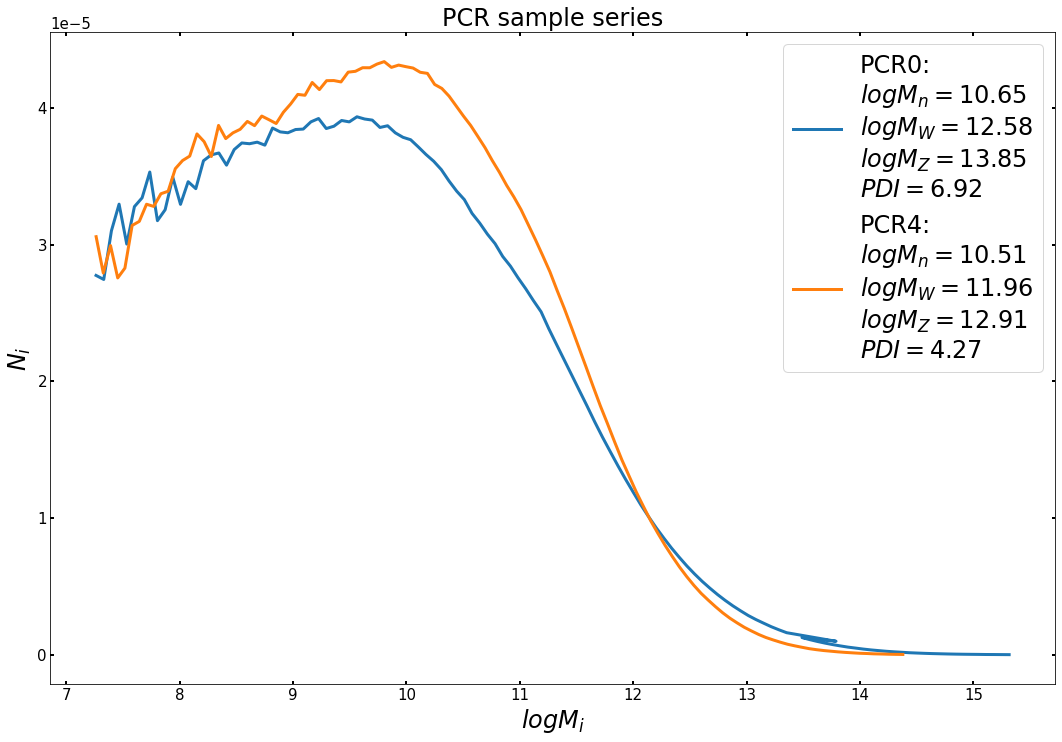

In [17]:
MWD('PCR', 'PCR sample series')

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

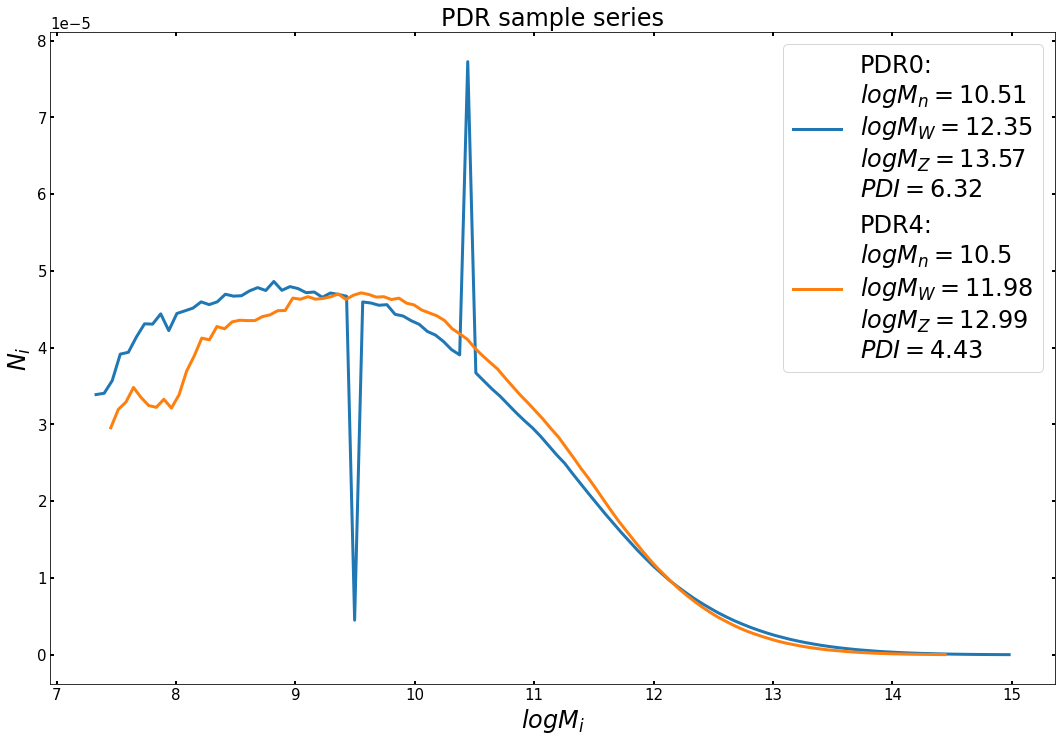

In [18]:
MWD('PDR', 'PDR sample series')

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

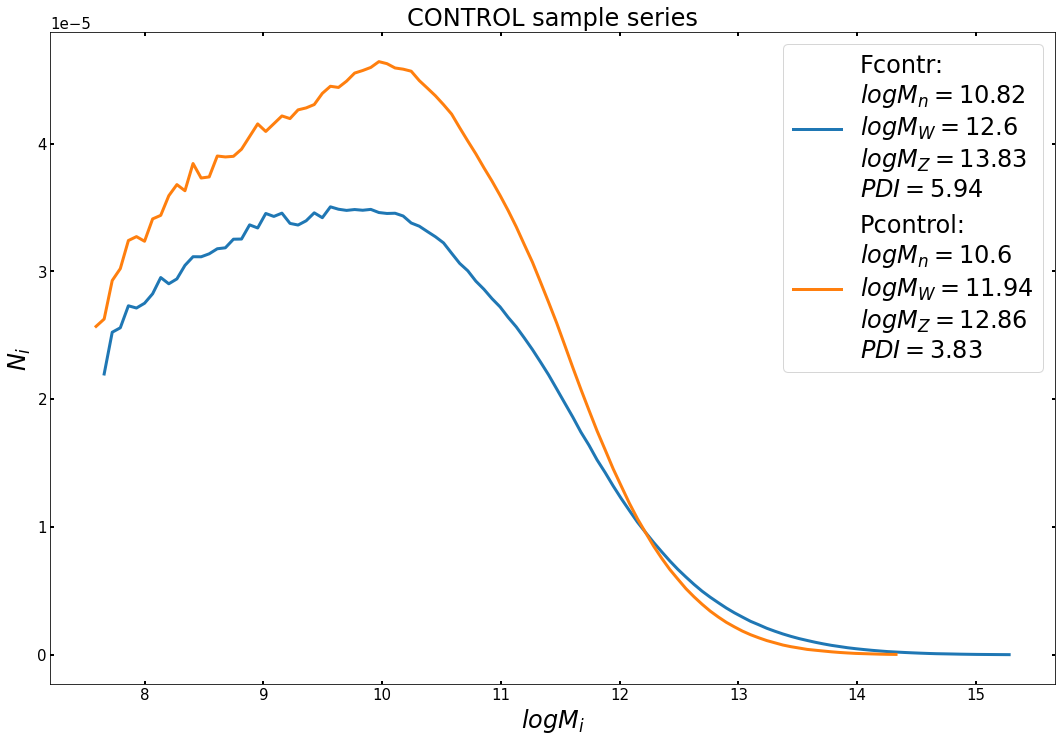

In [19]:
MWD('cont', 'CONTROL sample series')